###  **Importing Required Libraries and Configurations**
- Load essential libraries for:
- Data manipulation (`pandas`, `numpy`)
- Data visualization (`matplotlib`, `seaborn`)
- Machine learning and evaluation (`sklearn`)
- Suppress unnecessary warnings for cleaner output


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

## **EDA & Visualization**

In this section, we explore the distribution of the target variable (`Category`) and examine how it varies by gender.
This helps us understand potential class imbalance and any underlying patterns in the data.

###  **Category Distribution by Sex (Bar Plot**)
- Replaces `Sex` values for better interpretation (0 = Female, 1 = Male)
- Calculates percentage of each category split by gender
- Visualizes using side-by-side bar chart



In [2]:
df =pd.read_csv('HepatitisCdataa.csv')

In [3]:
df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,32,2,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106,12.1,69.0
1,0,32,2,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74,15.6,76.5
2,0,32,2,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86,33.2,79.3
3,0,32,2,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80,33.8,75.7
4,0,32,2,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76,29.9,68.7


In [4]:
df.shape

(612, 13)

In [5]:
df['Category'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [6]:
df['Sex'] = df['Sex'].replace({2: 1, 1: 0})

In [7]:
df['Sex'].unique()

array([1, 0], dtype=int64)

In [8]:
df.head(2)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,32,1,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106,12.1,69.0
1,0,32,1,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74,15.6,76.5


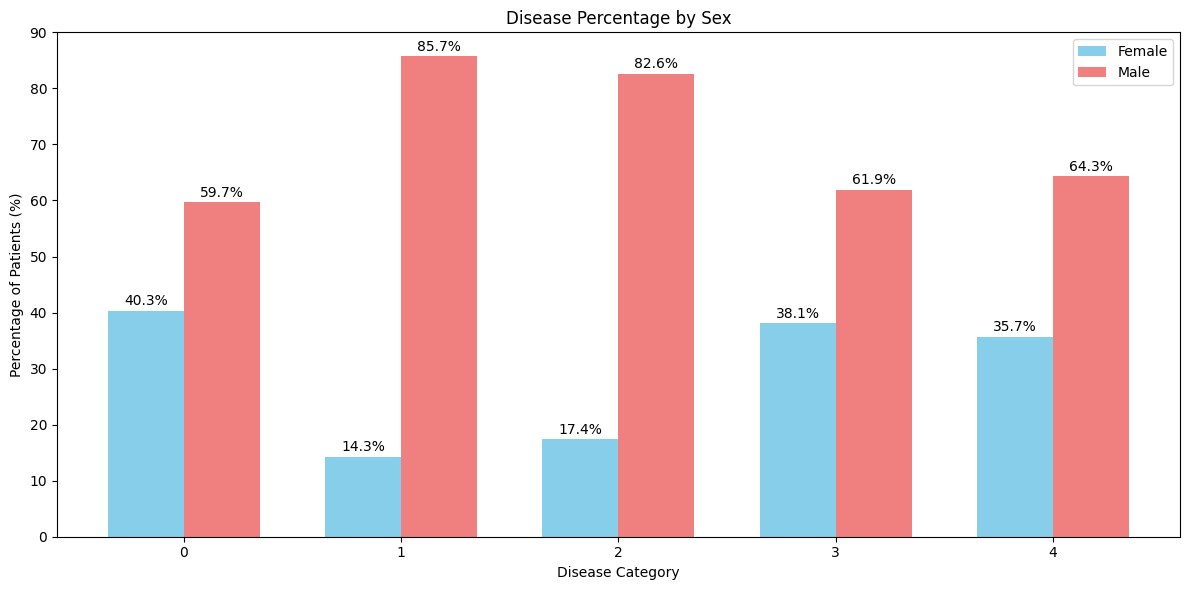

In [9]:
disease_percentages = df.groupby(['Category', 'Sex']).size().unstack(fill_value=0)
disease_percentages = disease_percentages.div(disease_percentages.sum(axis=1), axis=0) * 100

disease_categories = disease_percentages.index
x = np.arange(len(disease_categories))

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35

ax.bar(x - bar_width / 2, disease_percentages[0], bar_width, label='Female', color='skyblue')
ax.bar(x + bar_width / 2, disease_percentages[1], bar_width, label='Male', color='lightcoral')

ax.set_xlabel("Disease Category")
ax.set_ylabel("Percentage of Patients (%)")
ax.set_title("Disease Percentage by Sex")
ax.set_xticks(x)
ax.set_xticklabels(disease_categories)
ax.legend()

for i, category in enumerate(disease_categories):
    ax.text(x[i] - bar_width / 2, disease_percentages[0][category] + 1,
            f'{disease_percentages[0][category]:.1f}%', ha='center')
    ax.text(x[i] + bar_width / 2, disease_percentages[1][category] + 1,
            f'{disease_percentages[1][category]:.1f}%', ha='center')

plt.tight_layout()
plt.show()


In [10]:
df['Category'].value_counts()

Category
0    533
4     28
2     23
3     21
1      7
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution')

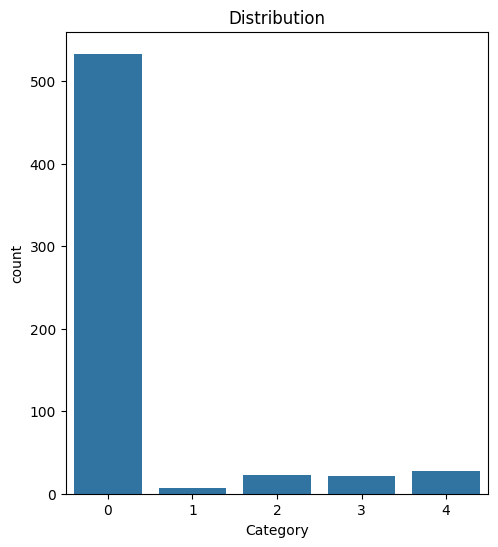

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=df['Category'])
plt.title('Distribution')

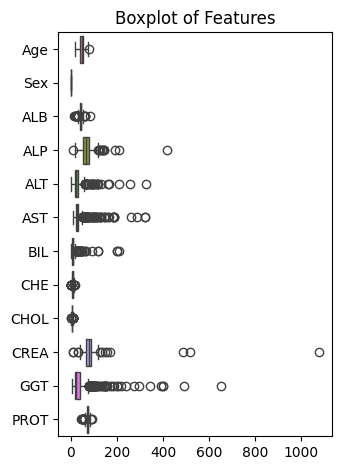

In [12]:
# plot outliers with boxplot and without category column
plt.subplot(1, 2, 2)
sns.boxplot(data=df.drop(columns=['Category']), orient='h')
plt.title('Boxplot of Features')
plt.tight_layout()
plt.show()


In [13]:
df.isnull().sum()

Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64

# **Data Preprocessing & Modeling**

## **Separating Data**

We separate the dataset into:
- **Features (`X`)**: All columns except the target (`Category`)
- **Target (`y`)**: The column we want to predict

In [14]:
X = df.drop('Category', axis=1)
y = df['Category']

### **Standardization**
Normalize the feature values using StandardScaler to improve model performance.

In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

###  **Train-Test Split**
Split the dataset into training and testing sets (80% train, 20% test).


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **SMOTE sampling**
Handle class imbalance using RandomOverSampler.


In [17]:
# use smote to balance the dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

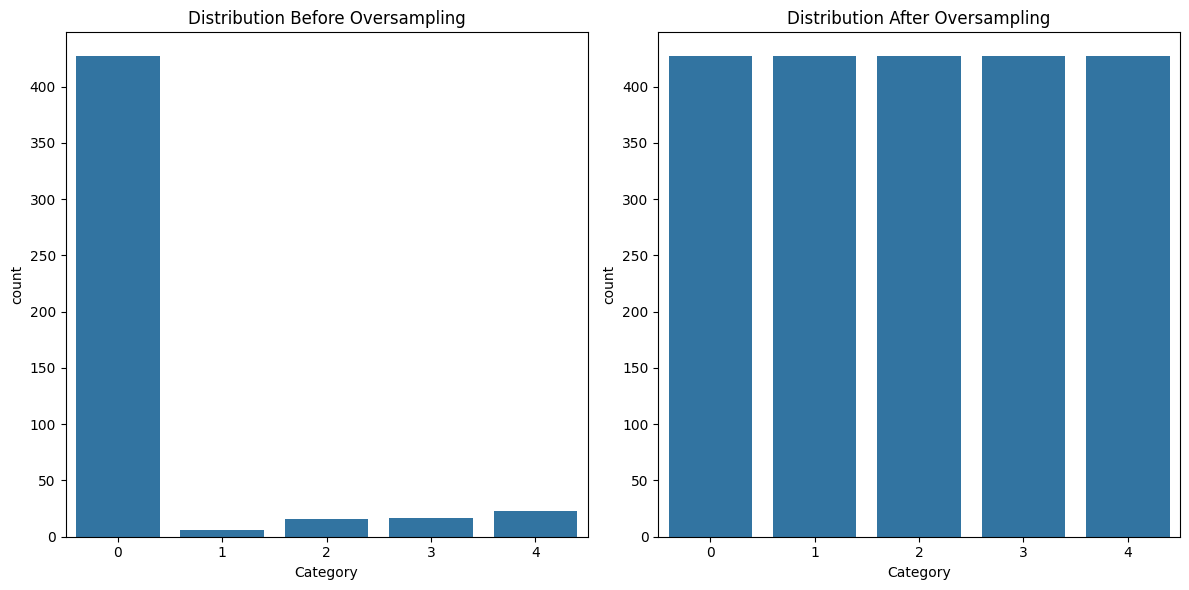

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Distribution Before Oversampling')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Distribution After Oversampling')

plt.tight_layout()
plt.show()

### **Model Training & Evaluation**
Train multiple classification models and evaluate their accuracy.


In [20]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)

    print(f"\n{model_name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted')) 
    print("Recall:", recall_score(y_test, y_pred, average='weighted')) 
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted')) 
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Random Forest Results:
Accuracy: 0.9512195121951219
Precision: 0.9500924448496821
Recall: 0.9512195121951219
F1 Score: 0.9503768493806282

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       106
           1       1.00      1.00      1.00         1
           2       0.83      0.71      0.77         7
           3       0.50      0.50      0.50         4
           4       1.00      1.00      1.00         5

    accuracy                           0.95       123
   macro avg       0.86      0.84      0.85       123
weighted avg       0.95      0.95      0.95       123


Confusion Matrix:
 [[104   0   1   1   0]
 [  0   1   0   0   0]
 [  1   0   5   1   0]
 [  2   0   0   2   0]
 [  0   0   0   0   5]]

Logistic Regression Results:
Accuracy: 0.8943089430894309
Precision: 0.9307007355787843
Recall: 0.8943089430894309
F1 Score: 0.908279350173181

Classification Report:
               precision    recall  f1-scor

### **Save the Best Model**
Save the Random Forest model using `joblib`.


In [22]:
import joblib

first_model_name = list(models.keys())[0]
first_model = models["Random Forest"]

joblib.dump(first_model, "RF VC.pkl")
print(f"{first_model_name} model saved successfully!")
joblib.dump(scaler,'scalerRF VC.pkl')
print(f"{scaler} model saved successfully!")

Random Forest model saved successfully!
StandardScaler() model saved successfully!


In [23]:
filtered_df = df[df['Category'] == 1].sample()
list_of_samples = filtered_df.values.tolist()

print(list_of_samples)

[[1.0, 49.0, 1.0, 21.6, 42.2, 9.5, 10.6, 2.4, 3.75, 3.01, 64.0, 38.9, 44.8]]


# **SIMPLE SYSTEM**

In [24]:
model = joblib.load('RF VC.pkl')
scaler = joblib.load('scalerRF VC.pkl')

In [26]:
user_input = [[49.0, 1.0, 21.6, 42.2, 9.5, 10.6, 2.4, 3.75, 3.01, 64.0, 38.9, 44.8]]

user_input = np.array(user_input).reshape(1, -1)
user_input = scaler.transform(user_input)

# Make prediction
prediction = model.predict(user_input)

# Print prediction
print(f"\nPrediction: The category is {prediction[0]}")


Prediction: The category is 1


In [28]:
from joblib import dump

# Save the model RANDOM FOREST
model2 = RandomForestClassifier()
model2.fit(X_train_resampled, y_train_resampled)
y_pred2 = model2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Precision:", precision_score(y_test, y_pred2, average='weighted'))

dump(model2, 'VC_model.joblib')

# Save the scaler
dump(scaler, 'VC_scaler.joblib')

Accuracy: 0.967479674796748
Precision: 0.9662766253830762


['VC_scaler.joblib']